### Summary:

    Careers Future data was srapped with search criteria = 'Data'. As the records proved extensive, further refinement
    was done during the EDA to remove unrelated jobs using conditions such as 
    1. Department contains Human Resource, and 2. where keywords in the job descriptions include 
    ['data', 'analyst', 'intelligence', 'python', 'analysis', 'trend', 'forecast']    
    
    2 models were used: Random Forest Classifier and Logistic Regression to identify between Low and High pay jobs
    
    To identify Low pay, the median salary was imputed by taking the median of the lower and upper range of each job.
    Low pay is subsequently defined as jobs where the median salary is LOWER than the mean of the population median salary.
    Feature engineering was done to further categorize the jobs into junior, mid and senior levels.
    
    Random Forest Classifier AUC score was 0.77 compared to Logistic Regression which was slighly better at 0.79.
    Random Forest Classifier accuracy was 0.6778 compared to Logisctic Regression which was 0.6764.
    
    NLP was utilised to given the string and descriptive nature of most fields used in the analysis. 
    This was applied on 4 fields (Job Title, Job Category, Job Description and Job Requirement)
    Each field has it's own stop word function initiated. CountVectoriser was initiated with stop_words = 'english' and 
    minimum frequency = 2. Textblob was also used to convert the text into individual words. Given more time, it would have 
    been more wholistic to examine ngram settings and other vectorisers to see if the score can be improved.
    
    For Qn2, we identified features related to Senior vs Non Senior positions given the NLP done ahead.
    Based on keywords assessment, it could be good to imply *information and technology sectors senior hiring is up* given the 
    Higher occurence of Info and Tech in the data scraping. *Team management* and *Project experience* could be very relevant
    too.
    
    On the flipside, adverts for non senior positions tend to include diploma in their requirements and words like adhoc in 
    job description. And job requirements for non senior positions typically include office/microsoft in the requirements.
    
    Top words which indicate senior positions are when 
    1. Job cateogry contains Information and Technology: Probability difference = 0.193883
    2. Job description contains design: Probability difference = 0.172098
    3. Job requirement contains years: Probability difference = 0.153097
    4. Job description contains team: Probability difference = 0.152212
    5. Job requirement contains strong: Probability difference = 0.142842
    6. Job requirement contains project: Probability difference = 0.132405

    -ve probability words to senior positions are when 
    1. Job description contains duties: Probability difference = -0.137142
    2. Job requirement contains diploma: Probability difference = -0.133004
    3. Job description contains adhoc: Probability difference = -0.108693
    4. Job description contains administrative: Probability difference = -0.092738
    5. Job category contains secretarial/admin: Probability difference = -0.090890
    6. Job requirement contains office/microsoft: Probability difference = -0.081182/-0.079360     
        
        
        
        

### Qn 1: To distinguish between high and low pay jobs

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('../jobs vertical.csv', sep = '|', index_col = False)

In [3]:
df = df.drop_duplicates('url')

In [4]:
df.columns

Index(['Unnamed: 0', 'url', 'co_name', 'title', 'locale', 'employtype',
       'senior', 'jobcategory', 'sal_lower', 'sal_upper', 'sal_freq', 'role',
       'job', 'require'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 0 to 2919
Data columns (total 14 columns):
Unnamed: 0     2920 non-null int64
url            2920 non-null object
co_name        2920 non-null object
title          2920 non-null object
locale         2920 non-null object
employtype     2920 non-null object
senior         2920 non-null object
jobcategory    2920 non-null object
sal_lower      2920 non-null object
sal_upper      2920 non-null object
sal_freq       2920 non-null object
role           2920 non-null object
job            2920 non-null object
require        2920 non-null object
dtypes: int64(1), object(13)
memory usage: 342.2+ KB


In [6]:
df.head(3)

,Unnamed: 0,url,co_name,title,locale,employtype,senior,jobcategory,sal_lower,sal_upper,sal_freq,role,job,require
0,0,https://www.mycareersfuture.sg/job/research-as...,['CAMBRIDGE CENTRE FOR ADVANCED RESEARCH AND E...,['Research Associate'],['1 CREATE WAY 138602'],['Full Time'],['Professional'],['Engineering'],"['$3,500']","['$5,000']",['Monthly'],['The selected candidate will support cutting-...,['<ul> <li> <p>Working with a multi-discipli...,['<ul> <li> <p>A good degree in a relevant d...
1,1,https://www.mycareersfuture.sg/job/software-de...,['CAMBRIDGE CENTRE FOR ADVANCED RESEARCH AND E...,['Software Developer'],['1 CREATE WAY 138602'],['Full Time'],['Professional'],"['Engineering, Information Technology, Science...","['$3,500']","['$5,000']",['Monthly'],[],['<ul> <li>build data models;</li> <li>vis...,['<ul> <li>A good bachelor degree in Compute...
2,2,https://www.mycareersfuture.sg/job/application...,['GENIEGOO PTE. LTD.'],['Application Consultant'],"['ZERVEX, 8 UBI ROAD 2 408538']",['Contract'],['Senior Executive'],['Information Technology'],"['$6,500']","['$8,500']",['Monthly'],[],[],[]


In [7]:
# remove square brackets from columns

df['co_name'] = df['co_name'].str.strip('[]')
df['title'] = df['title'].str.strip('[]')
df['locale'] = df['locale'].str.strip('[]')
df['employtype'] = df['employtype'].str.strip('[]')
df['senior'] = df['senior'].str.strip('[]')
df['jobcategory'] = df['jobcategory'].str.strip('[]')
df['sal_lower'] = df['sal_lower'].str.strip('[]')
df['sal_upper'] = df['sal_upper'].str.strip('[]')
df['sal_freq'] = df['sal_freq'].str.strip('[]')
df['role'] = df['role'].str.strip('[]')
df['job'] = df['job'].str.strip('[]')
df['require'] = df['require'].str.strip('[]')


In [8]:
# remove inverted commas from columns

df['co_name'] = df['co_name'].str.strip("'")
df['title'] = df['title'].str.strip("'")
df['locale'] = df['locale'].str.strip("'")
df['employtype'] = df['employtype'].str.strip("'")
df['senior'] = df['senior'].str.strip("'")
df['jobcategory'] = df['jobcategory'].str.strip("'")
df['sal_lower'] = df['sal_lower'].str.strip("'")
df['sal_upper'] = df['sal_upper'].str.strip("'")
df['sal_freq'] = df['sal_freq'].str.strip("'")
df['role'] = df['role'].str.strip("'")
df['job'] = df['job'].str.strip("'")
df['require'] = df['require'].str.strip("'")

In [9]:
# replace all empty cells with nan values

df = df.replace('', np.nan)

In [10]:
# data cleaning

# df = df.replace('<ul>', '')
# df = df.replace('<li>', '')
# df = df.replace('<p>', '')
# df = df.replace('\t', '')

In [11]:
# Drop rows where salary and job requirements contains NULL values

df = df[pd.notnull(df['sal_lower'])]
df = df[pd.notnull(df['sal_upper'])]
df = df[pd.notnull(df['require'])]

In [12]:
# Convert salary fields from string to integer

df['sal_lower'] = (df['sal_lower'].str.replace(r'[^-+\d.]', '').astype(int))
df['sal_upper'] = (df['sal_upper'].str.replace(r'[^-+\d.]', '').astype(int))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 0 to 2919
Data columns (total 14 columns):
Unnamed: 0     1729 non-null int64
url            1729 non-null object
co_name        1729 non-null object
title          1729 non-null object
locale         1335 non-null object
employtype     1729 non-null object
senior         1729 non-null object
jobcategory    1729 non-null object
sal_lower      1729 non-null int32
sal_upper      1729 non-null int32
sal_freq       1729 non-null object
role           834 non-null object
job            1474 non-null object
require        1729 non-null object
dtypes: int32(2), int64(1), object(11)
memory usage: 189.1+ KB


In [14]:
# scraping included Human Resource related jobs. View through all HR jobs and determined that HR jobs should be excluded.

pd.set_option('display.max_rows', None)
df[df['jobcategory'].str.contains("Human", na = False)]

,Unnamed: 0,url,co_name,title,locale,employtype,senior,jobcategory,sal_lower,sal_upper,sal_freq,role,job,require
5,5,https://www.mycareersfuture.sg/job/hr-generali...,LIVSPACE PTE. LTD.,HR Generalist,306 TANGLIN ROAD 247973,Permanent,Middle Management,Human Resources,4000,6000,Monthly,NaN,"""<ul> \t<li> \t<p>Responsible for full spectru...",<ul> \t<li> \t<p>5 - 7 years’ experience in th...
8,8,https://www.mycareersfuture.sg/job/hr-assistan...,HITACHI SOLUTIONS ASIA PACIFIC PTE. LTD.,HR Assistant / Executive Assistant - Singapore,"HITACHI SQUARE, 7 TAMPINES GRANDE 528736",Full Time,Non-executive,Human Resources,2000,3000,Monthly,NaN,<ul> \t<li>Administering and explaining benefi...,<ul> \t<li>At least 2 years related work exper...
21,21,https://www.mycareersfuture.sg/job/divisional-...,NANYANG TECHNOLOGICAL UNIVERSITY,"Divisional Head, HR Shared Services","NANYANG TECHNOLOGICAL UNIVERSITY, 50 NANYANG A...","Contract, Full Time",Senior Management,"Education and Training, Human Resources",9000,15000,Monthly,NaN,<ul> \t<li>Lead the Shared Service team to pro...,<ul> \t<li>At least 12 years of experience in ...
47,47,https://www.mycareersfuture.sg/job/hr-operatio...,ASIA PACIFIC BREWERIES (SINGAPORE) PTE LTD,HR Operations Manager,459 JALAN AHMAD IBRAHIM 639934,Permanent,"Manager, Senior Executive",Human Resources,6000,8500,Monthly,Deliver all aspects of HR to ensure the smooth...,<ul> \t<li>Ensuring HR processes are executed ...,<ul> \t<li>Prior experience in managing payrol...
169,169,https://www.mycareersfuture.sg/job/hr-officer-...,TRAQUE PTE. LTD.,HR Officer,"UNITY CENTRE, 51 BUKIT BATOK CRESCENT 658077","Part Time, Permanent, Full Time, Flexi work","Executive, Senior Executive",Human Resources,3000,6000,Monthly,"As part of a human resources team, the candida...",NaN,"""<ul> \t<li>Working with hiring managers to de..."
190,190,https://www.mycareersfuture.sg/job/recruiter-a...,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Recruiter,"AIA TOWER, 1 ROBINSON ROAD 048542",Full Time,Senior Executive,Human Resources,64000,128000,Annually,"""At Amazon.com, we're working to be the most c...","""<ul> \t<li>Work closely with business in orde...","<ul> </ul>', '<ul> \t<li>Bachelor or above deg..."
218,218,https://www.mycareersfuture.sg/job/organisatio...,LIBERTY WIRELESS PTE. LTD.,Organisational & Talent Development Specialist,"HENDERSON BUILDING, 221 HENDERSON ROAD 159557",Permanent,Executive,"Education and Training, Human Resources",3500,6900,Monthly,Circles.Life is Asia’s first and most successf...,<ul> \t<li>Assess the development needs of ide...,"<ul> \t<li>Bachelor degree in HR, Psychology o..."
233,233,https://www.mycareersfuture.sg/job/talent-acqu...,NCS PTE. LTD.,Talent Acquisition Manager,"NCS HUB, 5 ANG MO KIO STREET 62 569141","Permanent, Contract",Senior Executive,Human Resources,6000,7500,Monthly,We are scaling our teams for success and have ...,<ul> \t<li>Proactive consultative stakeholder ...,"<ul> \t<li>Good degree, and iHRP certification..."
312,312,https://www.mycareersfuture.sg/job/application...,IQ DYNAMICS PTE LTD,Application Developer & Support Consultant,"THYE HONG CENTRE, 2 LENG KEE ROAD 159086",Full Time,Executive,"Engineering, Human Resources , Information Tec...",3500,4300,Monthly,NaN,<ul> <li>Attend to customer support requests...,<ul> <li>Diploma or University Degree in Inf...
329,329,https://www.mycareersfuture.sg/job/senior-tech...,LIBERTY WIRELESS PTE. LTD.,senior technical recruiter,"HENDERSON BUILDING, 221 HENDERSON ROAD 159557",Full Time,Senior Executive,Human Resources,4000,7500,Monthly,NaN,<ul> <li>Take ownership of specific areas of...,"<ul> <li>Passionate about Technology, Disrup..."


In [15]:
# To remove all rows where job category contains Human

df = df[~df['jobcategory'].str.contains("Human", na = False)]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1659 entries, 0 to 2919
Data columns (total 14 columns):
Unnamed: 0     1659 non-null int64
url            1659 non-null object
co_name        1659 non-null object
title          1659 non-null object
locale         1281 non-null object
employtype     1659 non-null object
senior         1659 non-null object
jobcategory    1659 non-null object
sal_lower      1659 non-null int32
sal_upper      1659 non-null int32
sal_freq       1659 non-null object
role           800 non-null object
job            1408 non-null object
require        1659 non-null object
dtypes: int32(2), int64(1), object(11)
memory usage: 181.5+ KB


In [17]:
# Determine key words, look through Job column and filter for rows which contains the keywords

keys = ['data', 'analyst', 'intelligence', 'python', 'analysis', 'trend', 'forecast']
df = df[df['job'].str.contains('|'.join(keys), na = False)]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 2919
Data columns (total 14 columns):
Unnamed: 0     1206 non-null int64
url            1206 non-null object
co_name        1206 non-null object
title          1206 non-null object
locale         925 non-null object
employtype     1206 non-null object
senior         1206 non-null object
jobcategory    1206 non-null object
sal_lower      1206 non-null int32
sal_upper      1206 non-null int32
sal_freq       1206 non-null object
role           526 non-null object
job            1206 non-null object
require        1206 non-null object
dtypes: int32(2), int64(1), object(11)
memory usage: 131.9+ KB


In [19]:
df.head(3)

,Unnamed: 0,url,co_name,title,locale,employtype,senior,jobcategory,sal_lower,sal_upper,sal_freq,role,job,require
0,0,https://www.mycareersfuture.sg/job/research-as...,CAMBRIDGE CENTRE FOR ADVANCED RESEARCH AND EDU...,Research Associate,1 CREATE WAY 138602,Full Time,Professional,Engineering,3500,5000,Monthly,The selected candidate will support cutting-ed...,<ul> <li> <p>Working with a multi-disciplina...,<ul> <li> <p>A good degree in a relevant dis...
1,1,https://www.mycareersfuture.sg/job/software-de...,CAMBRIDGE CENTRE FOR ADVANCED RESEARCH AND EDU...,Software Developer,1 CREATE WAY 138602,Full Time,Professional,"Engineering, Information Technology, Sciences ...",3500,5000,Monthly,NaN,<ul> <li>build data models;</li> <li>visua...,<ul> <li>A good bachelor degree in Computer ...
9,9,https://www.mycareersfuture.sg/job/ui-ux-desig...,N4P PTE. LTD.,UI UX Design Lead,"APERIA, 12 KALLANG AVENUE 339511",Full Time,Professional,Design,4000,4500,Monthly,"You will strategize, execute and iterate on de...",<ul> <li>Work closely with various stakehold...,"""<ul> <li>1+ years of experience as a design..."


In [20]:
# Compute median salary based on range provided, applying different computation for Monthly vs Annual salary packages

df['sal_freq'].unique()

array(['Monthly', 'Annually'], dtype=object)

In [21]:
df['sal_median'] = df.apply(lambda x: (x.sal_upper+x.sal_lower)/2 if x.sal_freq == 'Monthly' else (x.sal_upper+x.sal_lower)/24, axis=1)

In [22]:
# Look through seniority to determine subclassification

df['senior'].unique()

array(['Professional', 'Executive', 'Manager', 'Senior Executive',
       'Middle Management',
       'Executive, Junior Executive, Senior Executive',
       'Senior Management', 'Junior Executive', 'Non-executive',
       'Fresh/entry level, Non-executive, Junior Executive',
       'Fresh/entry level, Executive',
       'Manager, Professional, Senior Executive', 'Manager, Professional',
       'Professional, Executive, Senior Executive', 'Fresh/entry level',
       'Fresh/entry level, Non-executive',
       'Professional, Executive, Junior Executive',
       'Senior Management, Professional', 'Executive, Junior Executive',
       'Executive, Senior Executive',
       'Senior Management, Middle Management',
       'Middle Management, Senior Executive',
       'Senior Management, Manager', 'Middle Management, Manager',
       'Middle Management, Manager, Professional',
       'Manager, Senior Executive', 'Middle Management, Executive',
       'Professional, Senior Executive', 'Professio

In [23]:
# Look through the seniority description and assign classes based on the hierarchy
def seniorityencode(df):
    
    keywords = ['Professional', 'Senior', 'Junior', 'Executive', 'Manager', 'Middle Management', 'Fresh', 'Non-executive']    
    
    # requirements to be classified as Senior
    if keywords[0] == df['senior']:
        return 'Senior'        # Professional only
    elif keywords[0] in df['senior'] and keywords[1] in df['senior'] and keywords[2] not in df['senior']:
        return 'Senior'        # Professional and senior but does not contain junior
    elif keywords[1] in df['senior'] and keywords[2] not in df['senior'] and keywords[6] not in df['senior']:
        return 'Senior'        # Senior but does not contain junior and does not contain fresh

    # requirements to be classified as Mid
    elif keywords[1] in df['senior'] and keywords[2] in df['senior']:
        return 'Mid'    
    elif keywords[3] in df['senior'] and keywords[6] not in df['senior']:
        return 'Mid' 
    elif keywords[4] in df['senior'] and keywords[6] not in df['senior']:
        return 'Mid' 
    elif keywords[5] in df['senior'] :
        return 'Mid'     

    # requirements to be classified as Junior
    elif keywords[6] in df['senior'] :
        return 'Junior'  
    elif keywords[7] in df['senior'] :
        return 'Junior'  
    
    # catch all for non classified
    else:
        return 'Unclassified'

df['seniority_level'] = df.apply(seniorityencode, axis = 1)

# check if unclassified is present. If present to reassign based on keywords
print(df['seniority_level'].unique())

['Senior' 'Mid' 'Junior']


In [24]:
# Visually look through count and description of seniority classes to determine suitability
# Adjust via function if not suitable

df.groupby(['seniority_level','senior'])['url'].count()

seniority_level  senior                                                      
Junior           Fresh/entry level                                                26
                 Fresh/entry level, Executive                                     13
                 Fresh/entry level, Executive, Non-executive                       3
                 Fresh/entry level, Executive, Senior Executive                    1
                 Fresh/entry level, Junior Executive                               2
                 Fresh/entry level, Non-executive                                 12
                 Fresh/entry level, Non-executive, Junior Executive               13
                 Fresh/entry level, Professional                                   2
                 Fresh/entry level, Professional, Executive                        1
                 Non-executive                                                   106
                 Professional, Non-executive                            

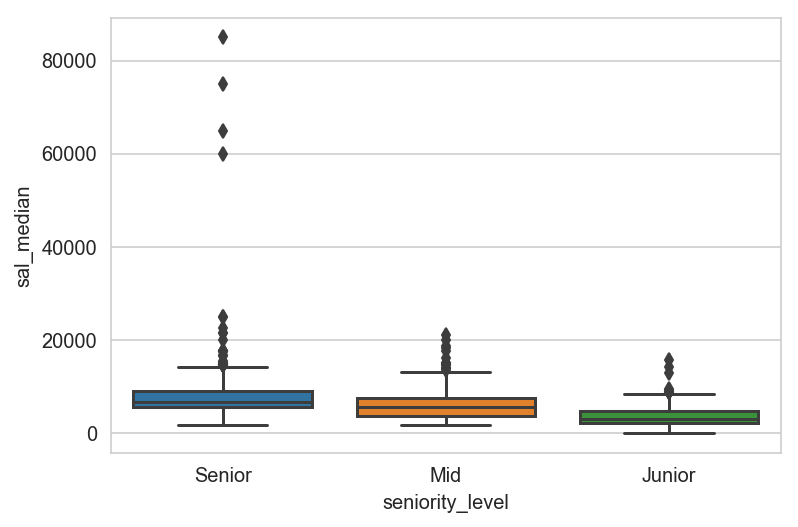

In [25]:
# boxplot to check distribution of median salary against seniority encoded.
# significant outliers in Senior Group. >$60k per month. drop 4 records out of >1k records

sns.boxplot(x='seniority_level',y='sal_median',data=df)

In [26]:
df[df['sal_median']>50000]

,Unnamed: 0,url,co_name,title,locale,employtype,senior,jobcategory,sal_lower,sal_upper,sal_freq,role,job,require,sal_median,seniority_level
816,816,https://www.mycareersfuture.sg/job/sr-clinical...,INC RESEARCH CRO SINGAPORE PTE. LTD.,SR Clinical Research Associate,137 TELOK AYER STREET 068602,"Permanent, Full Time","Professional, Executive, Senior Executive","Environment / Health , Healthcare / Pharmaceu...",80000,90000,Monthly,The Senior Clinical Research Associate I (Sr C...,<ul> \t<li>Monitoring</li> \t<li>Assures compl...,<ul> \t<li><strong>Years of experience require...,85000.0,Senior
824,824,https://www.mycareersfuture.sg/job/sr-site-sta...,INC RESEARCH CRO SINGAPORE PTE. LTD.,SR Site Start-up & Regulatory Specialist,137 TELOK AYER STREET 068602,"Permanent, Full Time","Professional, Senior Executive","Environment / Health , Healthcare / Pharmaceu...",70000,80000,Monthly,Performs assigned activities within the countr...,<ul> \t<li>General - Assumes responsibility on...,<ul> \t<li><strong>Years of experience require...,75000.0,Senior
1588,1588,https://www.mycareersfuture.sg/job/chief-opera...,ULTRA CLEAN ASIA PACIFIC PTE. LTD.,Chief Operationg Officer,"WOODLANDS SPECTRUM, 2 WOODLANDS SECTOR 1 738068","Permanent, Full Time",Senior Management,Manufacturing,40000,80000,Monthly,NaN,<ul> \t<li>Designing and implementing business...,<ul> \t<li>Operational expertise in manufactur...,60000.0,Senior
1899,1899,https://www.mycareersfuture.sg/job/senior-asso...,IHS MARKIT ASIA PTE. LTD.,"Senior Associate, Research and Analysis (Korea...",NaN,"Permanent, Full Time",Senior Executive,Banking and Finance,50000,80000,Monthly,NaN,<ul> <li>Analysis of company fundamentals to...,"<ul> <li>Undergraduate degree, preferably in...",65000.0,Senior


In [27]:
df = df.drop(df[df['sal_median'] > 50000].index)
df = df.reset_index(drop=True)

# df = df[df["score"] > 50]: alternative method

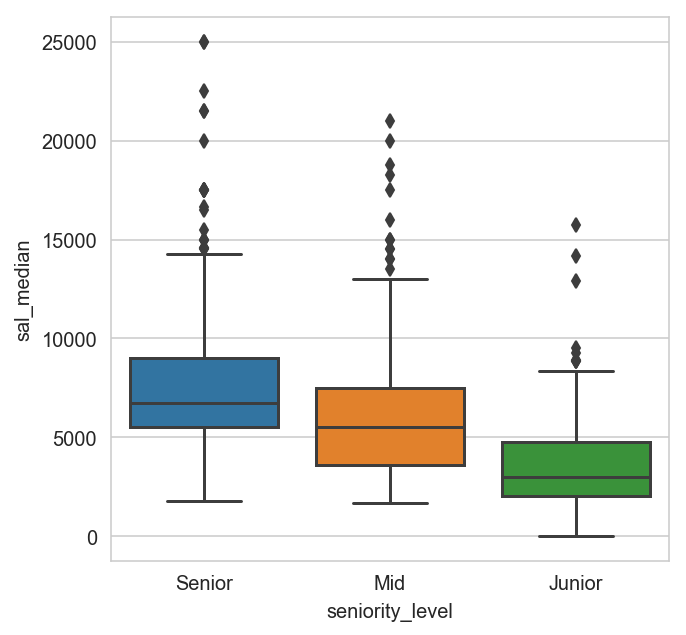

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='seniority_level',y='sal_median',data=df)

In [29]:
lower_than_med = []
for value in df['sal_median']:
    if value < df['sal_median'].mean():
        lower_than_med.append(1)
    else:
        lower_than_med.append(0)
        
df['lower_pay'] = lower_than_med

df.head()

,Unnamed: 0,url,co_name,title,locale,employtype,senior,jobcategory,sal_lower,sal_upper,sal_freq,role,job,require,sal_median,seniority_level,lower_pay
0,0,https://www.mycareersfuture.sg/job/research-as...,CAMBRIDGE CENTRE FOR ADVANCED RESEARCH AND EDU...,Research Associate,1 CREATE WAY 138602,Full Time,Professional,Engineering,3500,5000,Monthly,The selected candidate will support cutting-ed...,<ul> <li> <p>Working with a multi-disciplina...,<ul> <li> <p>A good degree in a relevant dis...,4250.0,Senior,1
1,1,https://www.mycareersfuture.sg/job/software-de...,CAMBRIDGE CENTRE FOR ADVANCED RESEARCH AND EDU...,Software Developer,1 CREATE WAY 138602,Full Time,Professional,"Engineering, Information Technology, Sciences ...",3500,5000,Monthly,NaN,<ul> <li>build data models;</li> <li>visua...,<ul> <li>A good bachelor degree in Computer ...,4250.0,Senior,1
2,9,https://www.mycareersfuture.sg/job/ui-ux-desig...,N4P PTE. LTD.,UI UX Design Lead,"APERIA, 12 KALLANG AVENUE 339511",Full Time,Professional,Design,4000,4500,Monthly,"You will strategize, execute and iterate on de...",<ul> <li>Work closely with various stakehold...,"""<ul> <li>1+ years of experience as a design...",4250.0,Senior,1
3,10,https://www.mycareersfuture.sg/job/performance...,VUNGLE SEA PTE. LTD.,Performance Optimization Analyst,NaN,Full Time,Executive,Advertising / Media,4000,6000,Monthly,NaN,<ul> <li>Drive optimization and strategy for...,<ul> <li>3-5 years of experience in online/m...,5000.0,Mid,1
4,11,https://www.mycareersfuture.sg/job/offine-mark...,FOODPANDA SINGAPORE PTE. LTD.,Offine Marketing Manager,"GB BUILDING, 143 CECIL STREET 069542",Full Time,Manager,Marketing / Public Relations,3000,4000,Monthly,Do you love food and convenience put together?...,<ul> \t<li> \t<p>Working closely with the Head...,<ul> \t<li> \t<p>2-4 years relevant work exper...,3500.0,Mid,1


In [30]:
df['employtype'].unique()

# Given employment type contains Full time / permanent in all records, treat the salary as quoted for Full/time staff.
# i.e. drop column employtype in regression subsequently

array(['Full Time', 'Permanent', 'Permanent, Full Time',
       'Contract, Full Time', 'Temporary, Contract', 'Contract',
       'Permanent, Contract', 'Permanent, Contract, Full Time',
       'Internship', 'Temporary, Full Time', 'Temporary',
       'Contract, Internship', 'Temporary, Contract, Full Time',
       'Permanent, Temporary, Contract', 'Full Time, Flexi work',
       'Part Time', 'Part Time, Full Time',
       'Part Time, Permanent, Full Time, Flexi work',
       'Part Time, Permanent, Freelance, Full Time, Internship'],
      dtype=object)

In [31]:
df['jobcategory'].unique()

# to use NLP and split into key words

array(['Engineering',
       'Engineering, Information Technology, Sciences / Laboratory / R&D',
       'Design', 'Advertising / Media ', 'Marketing / Public Relations ',
       'Others', 'Information Technology', 'Logistics / Supply Chain',
       'Advertising / Media , Information Technology, Others',
       'Consulting , Information Technology', 'Insurance',
       'Healthcare / Pharmaceutical', 'Accounting / Auditing / Taxation',
       'Education and Training', 'Admin / Secretarial',
       'Sciences / Laboratory / R&D', 'Sales / Retail ',
       'Banking and Finance, Information Technology',
       'General Management',
       'Accounting / Auditing / Taxation, Banking and Finance',
       'Admin / Secretarial, Manufacturing', 'Banking and Finance',
       'Admin / Secretarial, Customer Service', 'Hospitality',
       'Information Technology, Others', 'Legal',
       'Building and Construction', 'Engineering, Manufacturing',
       'Consulting , Building and Construction, Enginee

In [32]:
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import wordnet


In [33]:
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')

In [34]:
vect_title = []
for text in df['title']:
    vect = CountVectorizer(stop_words = 'english', min_df=2) ## initialize countvectorizer to capture stop words
    wnl = WordNetLemmatizer() ## initialize lemmatizer
    words = TextBlob(text).words ## convert into individual words
    wordList = [] 
    for word in words:
        wordList.append(wnl.lemmatize(word.lower(), pos='v')) ## capture verbs (not very necessary)
    vect_title.append(' '.join(wordList)) ## add string item into array
    
vect_titledf = pd.DataFrame(vect.fit_transform(vect_title).toarray(), columns=vect.get_feature_names()) ## make dataframe with vectorizer of lemmatized words

In [35]:
vect_titledf.columns = ['title_' + str(col) for col in vect_titledf.columns]
print(vect_titledf.columns)
print(vect_titledf.shape)

Index(['title_10', 'title_11', 'title_12', 'title_1800', 'title_180004ef',
       'title_1900007a', 'title_1900007n', 'title_190000hk', 'title_190000in',
       'title_190000ju',
       ...
       'title_vision', 'title_vp', 'title_warehouse', 'title_wealth',
       'title_web', 'title_west', 'title_work', 'title_xa0', 'title_year',
       'title_yield'],
      dtype='object', length=391)
(1202, 391)


In [36]:
vect_category = []
for text in df['jobcategory']:
    vect = CountVectorizer(stop_words = 'english', min_df=2) ## initialize countvectorizer to capture stop words
    wnl = WordNetLemmatizer() ## initialize lemmatizer
    words = TextBlob(text).words ## convert into individual words
    wordList = [] 
    for word in words:
        wordList.append(wnl.lemmatize(word.lower(), pos='v')) ## capture verbs (not very necessary)
    vect_category.append(' '.join(wordList)) ## add string item into array
    
vect_categorydf = pd.DataFrame(vect.fit_transform(vect_category).toarray(), columns=vect.get_feature_names()) ## make dataframe with vectorizer of lemmatized words

In [37]:
vect_categorydf.columns = ['category_' + str(col) for col in vect_categorydf.columns]
print(vect_categorydf.columns)
print(vect_categorydf.shape)

Index(['category_account', 'category_admin', 'category_advertise',
       'category_architecture', 'category_audit', 'category_bank',
       'category_build', 'category_chain', 'category_construction',
       'category_consult', 'category_customer', 'category_design',
       'category_education', 'category_engineer', 'category_entertainment',
       'category_environment', 'category_estate', 'category_events',
       'category_finance', 'category_general', 'category_health',
       'category_healthcare', 'category_hospitality', 'category_information',
       'category_insurance', 'category_interior', 'category_laboratory',
       'category_legal', 'category_logistics', 'category_maintenance',
       'category_management', 'category_manufacture', 'category_market',
       'category_media', 'category_medical', 'category_merchandise',
       'category_pharmaceutical', 'category_professional',
       'category_promotions', 'category_property', 'category_public',
       'category_purchase',

In [38]:
vect_jobd = []
for text in df['job']:
    vect = CountVectorizer(stop_words = 'english', min_df=2) ## initialize countvectorizer to capture stop words
    wnl = WordNetLemmatizer() ## initialize lemmatizer
    words = TextBlob(text).words ## convert into individual words
    wordList = [] 
    for word in words:
        wordList.append(wnl.lemmatize(word.lower(), pos='v')) ## capture verbs (not very necessary)
    vect_jobd.append(' '.join(wordList)) ## add string item into array
    
vect_jobddf = pd.DataFrame(vect.fit_transform(vect_jobd).toarray(), columns=vect.get_feature_names()) ## make dataframe with vectorizer of lemmatized words

In [39]:
vect_jobddf.columns = ['jobdesc_' + str(col) for col in vect_jobddf.columns]
print(vect_jobddf.columns)
print(vect_jobddf.shape)

Index(['jobdesc_000', 'jobdesc_10', 'jobdesc_100', 'jobdesc_11', 'jobdesc_12',
       'jobdesc_12c', 'jobdesc_14', 'jobdesc_15', 'jobdesc_17025',
       'jobdesc_1st',
       ...
       'jobdesc_xa0with', 'jobdesc_xampp', 'jobdesc_xml', 'jobdesc_year',
       'jobdesc_yearly', 'jobdesc_years', 'jobdesc_yield', 'jobdesc_youtube',
       'jobdesc_zero', 'jobdesc_zone'],
      dtype='object', length=4223)
(1202, 4223)


In [40]:
vect_require = []
for text in df['require']:
    vect = CountVectorizer(stop_words = 'english', min_df=2) ## initialize countvectorizer to capture stop words
    wnl = WordNetLemmatizer() ## initialize lemmatizer
    words = TextBlob(text).words ## convert into individual words
    wordList = [] 
    for word in words:
        wordList.append(wnl.lemmatize(word.lower(), pos='v')) ## capture verbs (not very necessary)
    vect_require.append(' '.join(wordList)) ## add string item into array
    
vect_requiredf = pd.DataFrame(vect.fit_transform(vect_require).toarray(), columns=vect.get_feature_names()) ## make dataframe with vectorizer of lemmatized words

In [41]:
vect_requiredf.columns = ['requirement_' + str(col) for col in vect_requiredf.columns]
print(vect_requiredf.columns)
print(vect_requiredf.shape)

Index(['requirement_00', 'requirement_10', 'requirement_10g',
       'requirement_10tb', 'requirement_11', 'requirement_110',
       'requirement_11pm', 'requirement_12', 'requirement_12c',
       'requirement_13485',
       ...
       'requirement_xp', 'requirement_yarn', 'requirement_year',
       'requirement_yearn', 'requirement_years', 'requirement_yield',
       'requirement_yrs', 'requirement_zendesk', 'requirement_zeromq',
       'requirement_zone'],
      dtype='object', length=3431)
(1202, 3431)


In [42]:
df_model = df[['lower_pay','seniority_level']].copy()
df_model = df_model.reset_index(drop=True)
print(df_model.shape)

# (not used) df_model1 = df.drop(columns=['Unnamed: 0','url','co_name','title','locale','employtype','senior','jobcategory','sal_lower','sal_upper','sal_freq','role'])

(1202, 2)


In [43]:
df_model.head(3)

,lower_pay,seniority_level
0,1,Senior
1,1,Senior
2,1,Senior


In [44]:
dummy = pd.get_dummies(df['seniority_level'],drop_first=True)
df_model = pd.concat([df_model,dummy],axis=1)
df_model.drop(columns=['seniority_level'], inplace=True)

In [45]:
df_model.head()

,lower_pay,Mid,Senior
0,1,0,1
1,1,0,1
2,1,0,1
3,1,1,0
4,1,1,0


In [46]:
df_model = pd.concat([df_model,vect_titledf], axis=1)
df_model = pd.concat([df_model,vect_categorydf], axis=1)
df_model = pd.concat([df_model,vect_jobddf],axis=1)
df_model = pd.concat([df_model,vect_requiredf], axis=1)

In [47]:
df_model.head(3)

,lower_pay,Mid,Senior,title_10,title_11,title_12,title_1800,title_180004ef,title_1900007a,title_1900007n,...,requirement_xp,requirement_yarn,requirement_year,requirement_yearn,requirement_years,requirement_yield,requirement_yrs,requirement_zendesk,requirement_zeromq,requirement_zone
0,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [48]:
from sklearn.model_selection import train_test_split
X = df_model.drop(columns=['lower_pay'])
ymin= df_model['lower_pay']
X_train, X_test, ymin_train, ymin_test = train_test_split(X,ymin)

In [49]:
# Fitting Random Forest Classification 
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 70, criterion = 'entropy', random_state = 0, min_samples_leaf = 3)
classifier.fit(X_train, ymin_train)

# Predicting the Test set results
ymin_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(ymin_test, ymin_pred), index = ['Lower Pay', 'Higher Pay'], columns=['Lower Pay (P)','Higher Pay (P)'])

cm

C:\Users\June\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,Lower Pay (P),Higher Pay (P)
Lower Pay,81,55
Higher Pay,16,149


In [50]:
#ROC/AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(ymin_test, ymin_pred)
roc_auc = auc(fpr, tpr)

roc_auc

0.7493092691622104

In [51]:
accuracy = cm.iloc[1,1]/(cm.iloc[0,0]+cm.iloc[1,1])
accuracy

0.6478260869565218

In [52]:
ymin.value_counts()

1    687
0    515
Name: lower_pay, dtype: int64

In [53]:
# Fitting using Logistic Regression

from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state = 0)
logr.fit(X_train, ymin_train)
print(logr.score(X_test, ymin_test))

# Predicting the Test set results
ymin_pred = logr.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(ymin_test, ymin_pred), index = ['Lower Pay', 'Higher Pay'], columns=['Lower Pay (P)','Higher Pay (P)'])

cm


# from sklearn.metrics import classification_report
# print(classification_report(yc_test, yc_pred))



0.7475083056478405


,Lower Pay (P),Higher Pay (P)
Lower Pay,85,51
Higher Pay,25,140


In [54]:
#ROC/AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(ymin_test, ymin_pred)
roc_auc = auc(fpr, tpr)

roc_auc

0.7367424242424242

In [55]:
accuracy = cm.iloc[1,1]/(cm.iloc[0,0]+cm.iloc[1,1])
accuracy

0.6222222222222222

### Qn 2: To identify features that distinguish Senior positions

In [56]:
dummy = pd.get_dummies(df['seniority_level'])


In [57]:
df_model2 = pd.concat([dummy,vect_titledf], axis=1)
df_model2 = pd.concat([df_model2,vect_categorydf], axis=1)
df_model2 = pd.concat([df_model2,vect_jobddf],axis=1)
df_model2 = pd.concat([df_model2,vect_requiredf], axis=1)

In [58]:
df_model2.head(10)

,Junior,Mid,Senior,title_10,title_11,title_12,title_1800,title_180004ef,title_1900007a,title_1900007n,...,requirement_xp,requirement_yarn,requirement_year,requirement_yearn,requirement_years,requirement_yield,requirement_yrs,requirement_zendesk,requirement_zeromq,requirement_zone
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [59]:
X = df_model2.drop(columns=['Junior','Mid','Senior'])
y = df_model2['Senior']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [60]:
X_train.shape, X_test.shape

((901, 8105), (301, 8105))

In [61]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

In [62]:
nb = BernoulliNB()

In [63]:
nb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [64]:
nb_scores = cross_val_score(BernoulliNB(), X_train, y_train, cv=5)
print(nb_scores)
print(np.mean(nb_scores))
print(np.mean(y_train))

[0.64088398 0.63535912 0.62983425 0.7150838  0.67597765]
0.659427760116053
0.38623751387347394


In [65]:
feat_lp = nb.feature_log_prob_

In [66]:
senior_p = np.exp(feat_lp[1])

In [67]:
non_senior_p = np.exp(feat_lp[0])

In [68]:
senior_p.shape

(8105,)

In [69]:
non_senior_p.shape

(8105,)

In [70]:
df_model2.head(1)

,Junior,Mid,Senior,title_10,title_11,title_12,title_1800,title_180004ef,title_1900007a,title_1900007n,...,requirement_xp,requirement_yarn,requirement_year,requirement_yearn,requirement_years,requirement_yield,requirement_yrs,requirement_zendesk,requirement_zeromq,requirement_zone
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [71]:
df_model2_words = df_model2.loc[:,'title_10':]
df_model2_words.shape

(1202, 8105)

In [72]:
df_model2_NB = pd.DataFrame({'senior_p':senior_p, 'non_senior_p':non_senior_p, 'words':df_model2_words.columns.values})

In [73]:
df_model2_NB['senior_diff'] = df_model2_NB['senior_p'] - df_model2_NB['non_senior_p']

In [74]:
df_model2_NB.sort_values('senior_diff', ascending=False, inplace=True)
df_model2_NB.head(20)

,senior_p,non_senior_p,words,senior_diff
444,0.471429,0.284685,category_technology,0.186744
414,0.471429,0.284685,category_information,0.186744
1525,0.445714,0.279279,jobdesc_design,0.166435
8099,0.691429,0.542342,requirement_years,0.149086
5588,0.294286,0.153153,requirement_development,0.141133
4201,0.600000,0.461261,jobdesc_team,0.138739
7120,0.320000,0.181982,requirement_project,0.138018
7581,0.234286,0.108108,requirement_sql,0.126178
7643,0.571429,0.446847,requirement_strong,0.124582
320,0.242857,0.118919,title_senior,0.123938


In [75]:
df_model2_NB.sort_values('senior_diff', ascending=True, inplace=True)
df_model2_NB.head(20)

,senior_p,non_senior_p,words,senior_diff
5614,0.077143,0.209009,requirement_diploma,-0.131866
1674,0.082857,0.203604,jobdesc_duties,-0.120746
552,0.045714,0.149550,jobdesc_ad,-0.103835
2195,0.042857,0.140541,jobdesc_hoc,-0.097683
1792,0.022857,0.117117,jobdesc_entry,-0.094260
440,0.017143,0.102703,category_secretarial,-0.085560
392,0.017143,0.102703,category_admin,-0.085560
209,0.120000,0.203604,title_manager,-0.083604
575,0.042857,0.118919,jobdesc_administrative,-0.076062
6045,0.357143,0.419820,requirement_good,-0.062677
